In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "DecreaseLearningRateNoearlystop.h5py"

In [3]:
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_m', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
# output_keys = ['th_eta','th_phi', 'tl_eta', 'tl_phi']

output_length = len(output_keys)

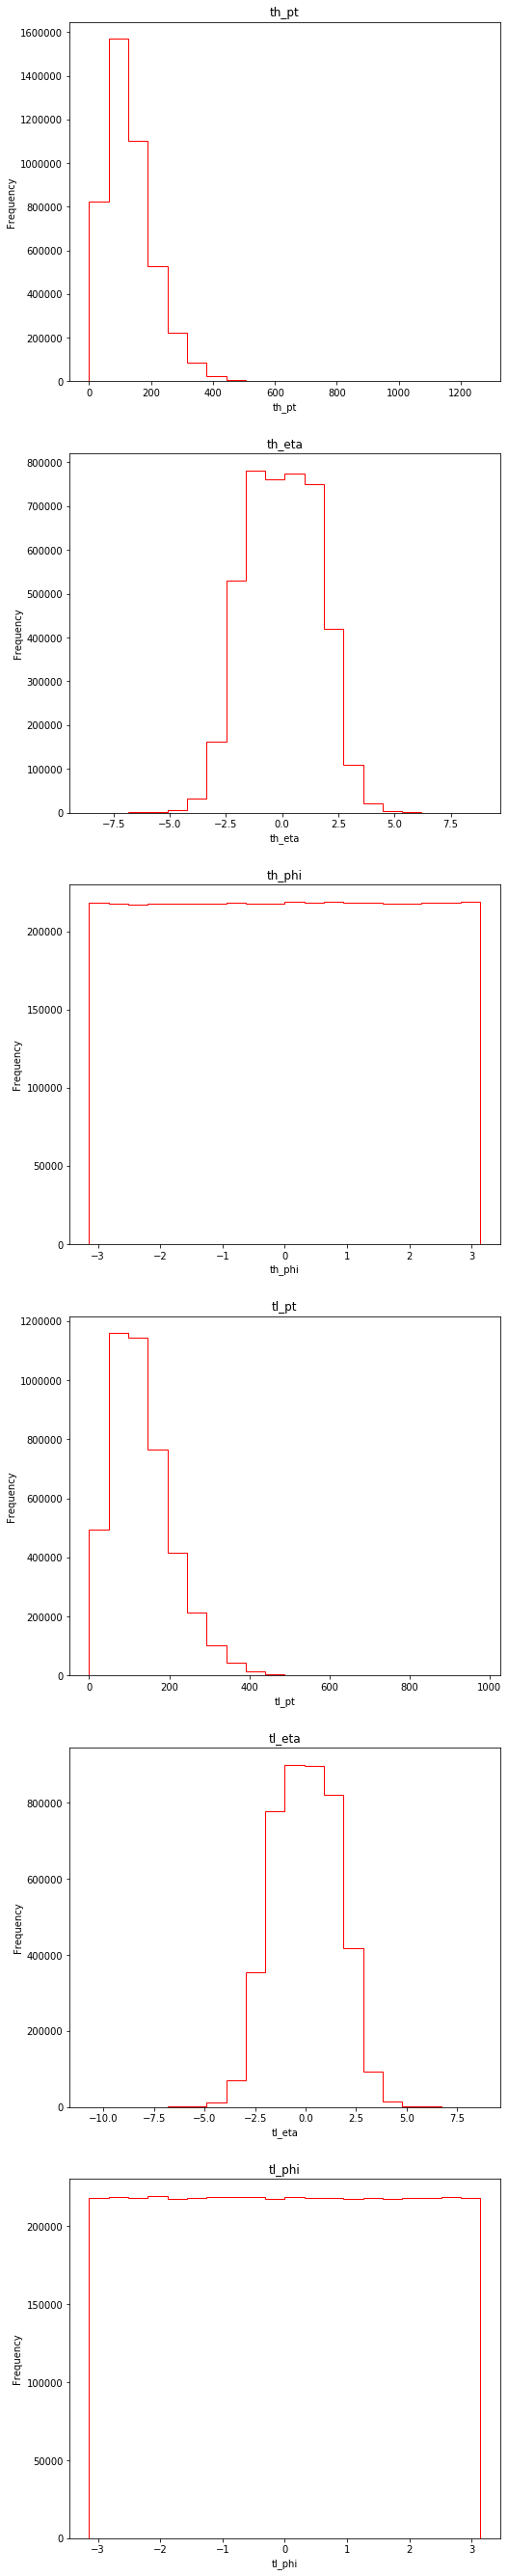

In [5]:
# Original variables

plt.figure(figsize=(8,8*output_length))
for i in range(0, output_length):
    plt.subplot(output_length,1,i+1)
    plt.hist(dataset.get(output_keys[i]), 20, histtype = 'step', color='r')
    plt.xlabel(output_keys[i])
    plt.ylabel('Frequency')
    plt.title(output_keys[i])

In [6]:
# Convert into numpy arrays and mean normalize
crop =  100000

input_arrays = []
output_arrays = [] 
in_std = []
in_mean = []
out_std = []
out_mean = []

# for key in input_keys:
#     exec(key + ' = np.array(dataset.get(key))[0:crop].reshape((1,-1))')
#     exec('{0} = ({0} - np.mean({0}))/np.std({0})'.format(key))
#     exec('input_arrays.append({0})'.format(key))

    
def convert_normalize(keys, std, mean, total):
    for x in keys:
        var = np.array(dataset.get(x))[0:crop].reshape((1,-1))
        sig = np.std(var)
        mu = np.mean(var)
        std.append(sig)
        mean.append(mu)
        var = (var - mu)/sig 
        total.append(var)

    
convert_normalize(input_keys, in_std, in_mean, input_arrays)
convert_normalize(output_keys, out_std, out_mean, output_arrays)

out_std = np.array(out_std).reshape((1,-1))
out_mean = np.array(out_mean).reshape((1,-1))
in_std = np.array(in_std).reshape((1,-1))
in_mean = np.array(in_mean).reshape((1,-1))

In [7]:
# Create input and test array
split = int(np.floor(0.8*crop)) # 80/20 split 
shuffle = True
    
total_input = np.stack(input_arrays).reshape((crop, len(input_keys)))
total_output = np.stack(output_arrays).reshape((crop, len(output_keys)))

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)
    
# size = total_input.shape
# total_input = np.array(np.random.normal(size=total_input.shape))

train_input, test_input = total_input[0:split, :], total_input[split:, :]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [8]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 46) (80000, 6)
(20000, 46) (20000, 6)


In [9]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(128,  activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [10]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6016      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 31,174
Trainable params: 31,174
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=True, 
                   batch_size=512)


Epoch 1/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.1289 - mse: 1.1221 - val_loss: 1.1206 - val_mse: 1.1137
Epoch 2/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.1204 - mse: 1.1136 - val_loss: 1.1125 - val_mse: 1.1057
Epoch 3/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.1127 - mse: 1.1058 - val_loss: 1.1052 - val_mse: 1.0984
Epoch 4/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.1057 - mse: 1.0988 - val_loss: 1.0986 - val_mse: 1.0918
Epoch 5/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0993 - mse: 1.0925 - val_loss: 1.0926 - val_mse: 1.0858
Epoch 6/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0935 - mse: 1.0867 - val_loss: 1.0872 - val_mse: 1.0803
Epoch 7/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0883 - mse: 1.0814 - val_loss: 1.0823 - val_mse: 1.0754
Epoch 8/2048
125/125 [==============================] - 0s 4ms

Epoch 62/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0300 - mse: 1.0232 - val_loss: 1.0273 - val_mse: 1.0206
Epoch 63/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0297 - mse: 1.0229 - val_loss: 1.0271 - val_mse: 1.0203
Epoch 64/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0294 - mse: 1.0226 - val_loss: 1.0268 - val_mse: 1.0200
Epoch 65/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0291 - mse: 1.0223 - val_loss: 1.0265 - val_mse: 1.0197
Epoch 66/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0288 - mse: 1.0220 - val_loss: 1.0263 - val_mse: 1.0195
Epoch 67/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0285 - mse: 1.0218 - val_loss: 1.0260 - val_mse: 1.0192
Epoch 68/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0283 - mse: 1.0215 - val_loss: 1.0257 - val_mse: 1.0190
Epoch 69/2048
125/125 [==============================] 

125/125 [==============================] - 0s 4ms/step - loss: 1.0184 - mse: 1.0117 - val_loss: 1.0168 - val_mse: 1.0101
Epoch 123/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0183 - mse: 1.0116 - val_loss: 1.0167 - val_mse: 1.0100
Epoch 124/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0182 - mse: 1.0115 - val_loss: 1.0166 - val_mse: 1.0099
Epoch 125/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0181 - mse: 1.0114 - val_loss: 1.0165 - val_mse: 1.0097
Epoch 126/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0180 - mse: 1.0113 - val_loss: 1.0164 - val_mse: 1.0096
Epoch 127/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0179 - mse: 1.0111 - val_loss: 1.0163 - val_mse: 1.0095
Epoch 128/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0177 - mse: 1.0110 - val_loss: 1.0162 - val_mse: 1.0095
Epoch 129/2048
125/125 [==============================] - 1s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0132 - mse: 1.0065 - val_loss: 1.0122 - val_mse: 1.0055
Epoch 183/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0131 - mse: 1.0064 - val_loss: 1.0121 - val_mse: 1.0054
Epoch 184/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0131 - mse: 1.0064 - val_loss: 1.0121 - val_mse: 1.0054
Epoch 185/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0130 - mse: 1.0063 - val_loss: 1.0120 - val_mse: 1.0053
Epoch 186/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0129 - mse: 1.0063 - val_loss: 1.0120 - val_mse: 1.0053
Epoch 187/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0129 - mse: 1.0062 - val_loss: 1.0119 - val_mse: 1.0052
Epoch 188/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0128 - mse: 1.0061 - val_loss: 1.0118 - val_mse: 1.0052
Epoch 189/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0102 - mse: 1.0036 - val_loss: 1.0097 - val_mse: 1.0031
Epoch 243/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0102 - mse: 1.0035 - val_loss: 1.0097 - val_mse: 1.0031
Epoch 244/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0101 - mse: 1.0035 - val_loss: 1.0097 - val_mse: 1.0030
Epoch 245/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0101 - mse: 1.0035 - val_loss: 1.0096 - val_mse: 1.0030
Epoch 246/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0101 - mse: 1.0034 - val_loss: 1.0096 - val_mse: 1.0030
Epoch 247/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0100 - mse: 1.0034 - val_loss: 1.0096 - val_mse: 1.0030
Epoch 248/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0100 - mse: 1.0034 - val_loss: 1.0096 - val_mse: 1.0029
Epoch 249/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0084 - mse: 1.0018 - val_loss: 1.0083 - val_mse: 1.0017
Epoch 303/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0083 - mse: 1.0017 - val_loss: 1.0083 - val_mse: 1.0017
Epoch 304/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0083 - mse: 1.0017 - val_loss: 1.0083 - val_mse: 1.0017
Epoch 305/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0083 - mse: 1.0017 - val_loss: 1.0083 - val_mse: 1.0017
Epoch 306/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0083 - mse: 1.0017 - val_loss: 1.0083 - val_mse: 1.0017
Epoch 307/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0082 - mse: 1.0016 - val_loss: 1.0082 - val_mse: 1.0017
Epoch 308/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0082 - mse: 1.0016 - val_loss: 1.0082 - val_mse: 1.0016
Epoch 309/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0071 - mse: 1.0005 - val_loss: 1.0075 - val_mse: 1.0009
Epoch 363/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0070 - mse: 1.0005 - val_loss: 1.0075 - val_mse: 1.0009
Epoch 364/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0070 - mse: 1.0005 - val_loss: 1.0074 - val_mse: 1.0009
Epoch 365/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0070 - mse: 1.0004 - val_loss: 1.0074 - val_mse: 1.0009
Epoch 366/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0070 - mse: 1.0004 - val_loss: 1.0074 - val_mse: 1.0009
Epoch 367/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0070 - mse: 1.0004 - val_loss: 1.0074 - val_mse: 1.0009
Epoch 368/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0070 - mse: 1.0004 - val_loss: 1.0074 - val_mse: 1.0008
Epoch 369/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0061 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0004
Epoch 423/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0061 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0004
Epoch 424/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0060 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0004
Epoch 425/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0060 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0004
Epoch 426/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0060 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0004
Epoch 427/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0060 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0003
Epoch 428/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0060 - mse: 0.9995 - val_loss: 1.0069 - val_mse: 1.0003
Epoch 429/2048
125/125 [==============================] - 1s 4m

125/125 [==============================] - 1s 4ms/step - loss: 1.0053 - mse: 0.9988 - val_loss: 1.0066 - val_mse: 1.0001
Epoch 483/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0052 - mse: 0.9988 - val_loss: 1.0066 - val_mse: 1.0001
Epoch 484/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0052 - mse: 0.9987 - val_loss: 1.0065 - val_mse: 1.0001
Epoch 485/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0052 - mse: 0.9987 - val_loss: 1.0065 - val_mse: 1.0001
Epoch 486/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0052 - mse: 0.9987 - val_loss: 1.0065 - val_mse: 1.0000
Epoch 487/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0052 - mse: 0.9987 - val_loss: 1.0065 - val_mse: 1.0000
Epoch 488/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0052 - mse: 0.9987 - val_loss: 1.0065 - val_mse: 1.0000
Epoch 489/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 1s 4ms/step - loss: 1.0046 - mse: 0.9981 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 543/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0045 - mse: 0.9981 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 544/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0045 - mse: 0.9981 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 545/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0045 - mse: 0.9981 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 546/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0045 - mse: 0.9980 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 547/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0045 - mse: 0.9980 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 548/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0045 - mse: 0.9980 - val_loss: 1.0063 - val_mse: 0.9999
Epoch 549/2048
125/125 [==============================] - 1s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0039 - mse: 0.9975 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 603/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0039 - mse: 0.9975 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 604/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0039 - mse: 0.9975 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 605/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0039 - mse: 0.9975 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 606/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0039 - mse: 0.9975 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 607/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0039 - mse: 0.9974 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 608/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0039 - mse: 0.9974 - val_loss: 1.0062 - val_mse: 0.9998
Epoch 609/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 1s 4ms/step - loss: 1.0034 - mse: 0.9970 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 663/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 664/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 665/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 666/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 667/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 668/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0033 - mse: 0.9969 - val_loss: 1.0061 - val_mse: 0.9997
Epoch 669/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 723/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 724/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 725/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 726/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 727/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 728/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0028 - mse: 0.9964 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 729/2048
125/125 [==============================] - 1s 4m

125/125 [==============================] - 1s 4ms/step - loss: 1.0023 - mse: 0.9960 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 783/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0023 - mse: 0.9960 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 784/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0023 - mse: 0.9960 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 785/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0023 - mse: 0.9960 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 786/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0023 - mse: 0.9959 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 787/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0023 - mse: 0.9959 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 788/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0023 - mse: 0.9959 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 789/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0019 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 843/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 844/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 845/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 846/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 847/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 848/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0018 - mse: 0.9955 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 849/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 903/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 904/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 905/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 906/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 907/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 908/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0014 - mse: 0.9951 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 909/2048
125/125 [==============================] - 1s 4m

125/125 [==============================] - 0s 4ms/step - loss: 1.0010 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 963/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0010 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 964/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 965/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 966/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 967/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 0.9947 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 968/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 0.9946 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 969/2048
125/125 [==============================] - 0s 4m

125/125 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1023/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1024/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1025/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1026/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1027/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0005 - mse: 0.9943 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1028/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0005 - mse: 0.9942 - val_loss: 1.0060 - val_mse: 0.9997
Epoch 1029/2048
125/125 [==============================] 

Epoch 1082/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1083/2048
125/125 [==============================] - 0s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1084/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1085/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1086/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1087/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1088/2048
125/125 [==============================] - 1s 4ms/step - loss: 1.0001 - mse: 0.9939 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1089/2048
125/125 [================

Epoch 1142/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1143/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1144/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1145/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1146/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1147/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1148/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9997 - mse: 0.9935 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1149/2048
125/125 [================

Epoch 1202/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9932 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1203/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1204/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1205/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1206/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1207/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1208/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9993 - mse: 0.9931 - val_loss: 1.0060 - val_mse: 0.9998
Epoch 1209/2048
125/125 [================

Epoch 1262/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9990 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1263/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9990 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1264/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9989 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1265/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9989 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1266/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9989 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1267/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9989 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1268/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9989 - mse: 0.9928 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1269/2048
125/125 [================

Epoch 1322/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1323/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1324/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1325/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1326/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1327/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1328/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9986 - mse: 0.9924 - val_loss: 1.0060 - val_mse: 0.9999
Epoch 1329/2048
125/125 [================

Epoch 1382/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1383/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1384/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1385/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1386/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1387/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1388/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9982 - mse: 0.9921 - val_loss: 1.0061 - val_mse: 0.9999
Epoch 1389/2048
125/125 [================

Epoch 1442/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9979 - mse: 0.9918 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1443/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9979 - mse: 0.9918 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1444/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9979 - mse: 0.9918 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1445/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9979 - mse: 0.9918 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1446/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9979 - mse: 0.9917 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1447/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9979 - mse: 0.9917 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1448/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9978 - mse: 0.9917 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1449/2048
125/125 [================

Epoch 1502/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1503/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1504/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1505/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1506/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1507/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1508/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9975 - mse: 0.9914 - val_loss: 1.0061 - val_mse: 1.0000
Epoch 1509/2048
125/125 [================

Epoch 1562/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1563/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1564/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1565/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1566/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1567/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1568/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9972 - mse: 0.9911 - val_loss: 1.0062 - val_mse: 1.0001
Epoch 1569/2048
125/125 [================

Epoch 1622/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9969 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1623/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9969 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1624/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9968 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1625/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9968 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1626/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9968 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1627/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9968 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1628/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9968 - mse: 0.9908 - val_loss: 1.0062 - val_mse: 1.0002
Epoch 1629/2048
125/125 [================

Epoch 1682/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1683/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1684/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1685/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1686/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1687/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9965 - mse: 0.9905 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1688/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9965 - mse: 0.9904 - val_loss: 1.0063 - val_mse: 1.0002
Epoch 1689/2048
125/125 [================

Epoch 1742/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9962 - mse: 0.9902 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1743/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9962 - mse: 0.9902 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1744/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9962 - mse: 0.9901 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1745/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9962 - mse: 0.9901 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1746/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9962 - mse: 0.9901 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1747/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9962 - mse: 0.9901 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1748/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9962 - mse: 0.9901 - val_loss: 1.0063 - val_mse: 1.0003
Epoch 1749/2048
125/125 [================

Epoch 1802/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9959 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1803/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9959 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1804/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9959 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1805/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9958 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1806/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9958 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1807/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9958 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1808/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9958 - mse: 0.9898 - val_loss: 1.0064 - val_mse: 1.0003
Epoch 1809/2048
125/125 [================

Epoch 1862/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1863/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1864/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1865/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1866/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1867/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1868/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9955 - mse: 0.9895 - val_loss: 1.0064 - val_mse: 1.0004
Epoch 1869/2048
125/125 [================

Epoch 1922/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1923/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1924/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1925/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1926/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1927/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1928/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9952 - mse: 0.9892 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1929/2048
125/125 [================

Epoch 1982/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1983/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1984/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1985/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0005
Epoch 1986/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0006
Epoch 1987/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0006
Epoch 1988/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9949 - mse: 0.9889 - val_loss: 1.0065 - val_mse: 1.0006
Epoch 1989/2048
125/125 [================

Epoch 2042/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9946 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2043/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9946 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2044/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9946 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2045/2048
125/125 [==============================] - 0s 4ms/step - loss: 0.9946 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2046/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9945 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2047/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9945 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006
Epoch 2048/2048
125/125 [==============================] - 1s 4ms/step - loss: 0.9945 - mse: 0.9886 - val_loss: 1.0066 - val_mse: 1.0006


In [12]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: DecreaseLearningRateNoearlystop.h5py/assets


Text(0.5, 1.0, 'MSE loss')

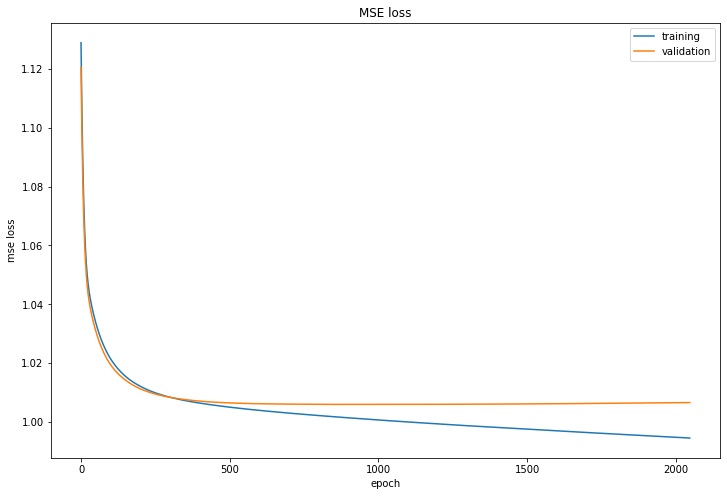

In [13]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [14]:
predictions = model.predict(test_input)

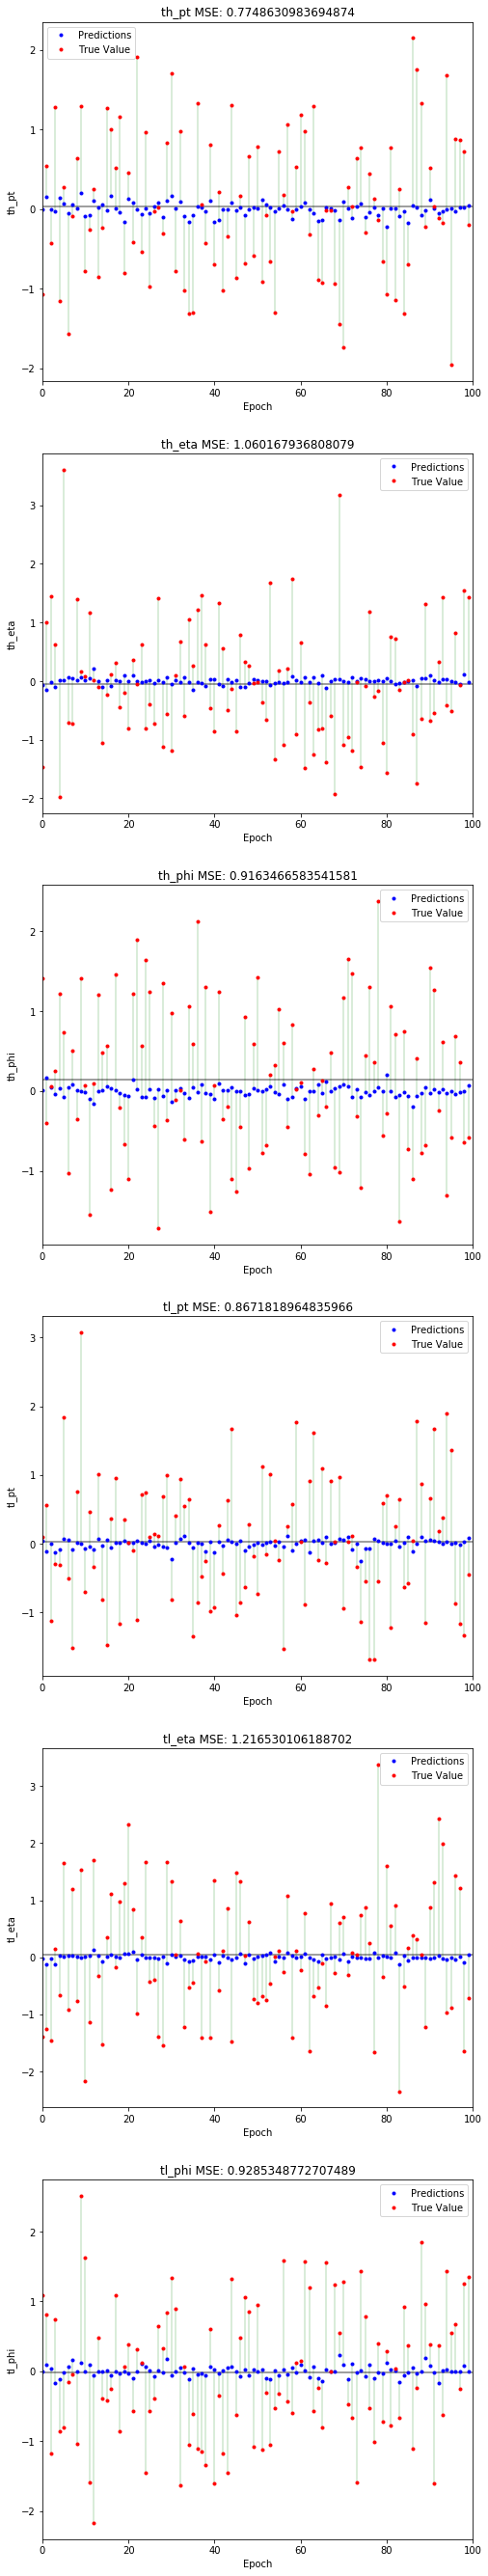

In [15]:
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [16]:
# Predictions

predictions_small = predictions[0:crop,:]
test_output_small = test_output[0:crop,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 1.0088088134494049
th_pt MSE :  1.0092444850
th_eta MSE :  1.0154326113
th_phi MSE :  0.9882910388
tl_pt MSE :  1.0099808408
tl_eta MSE :  1.0124875036
tl_phi MSE :  1.0174164012


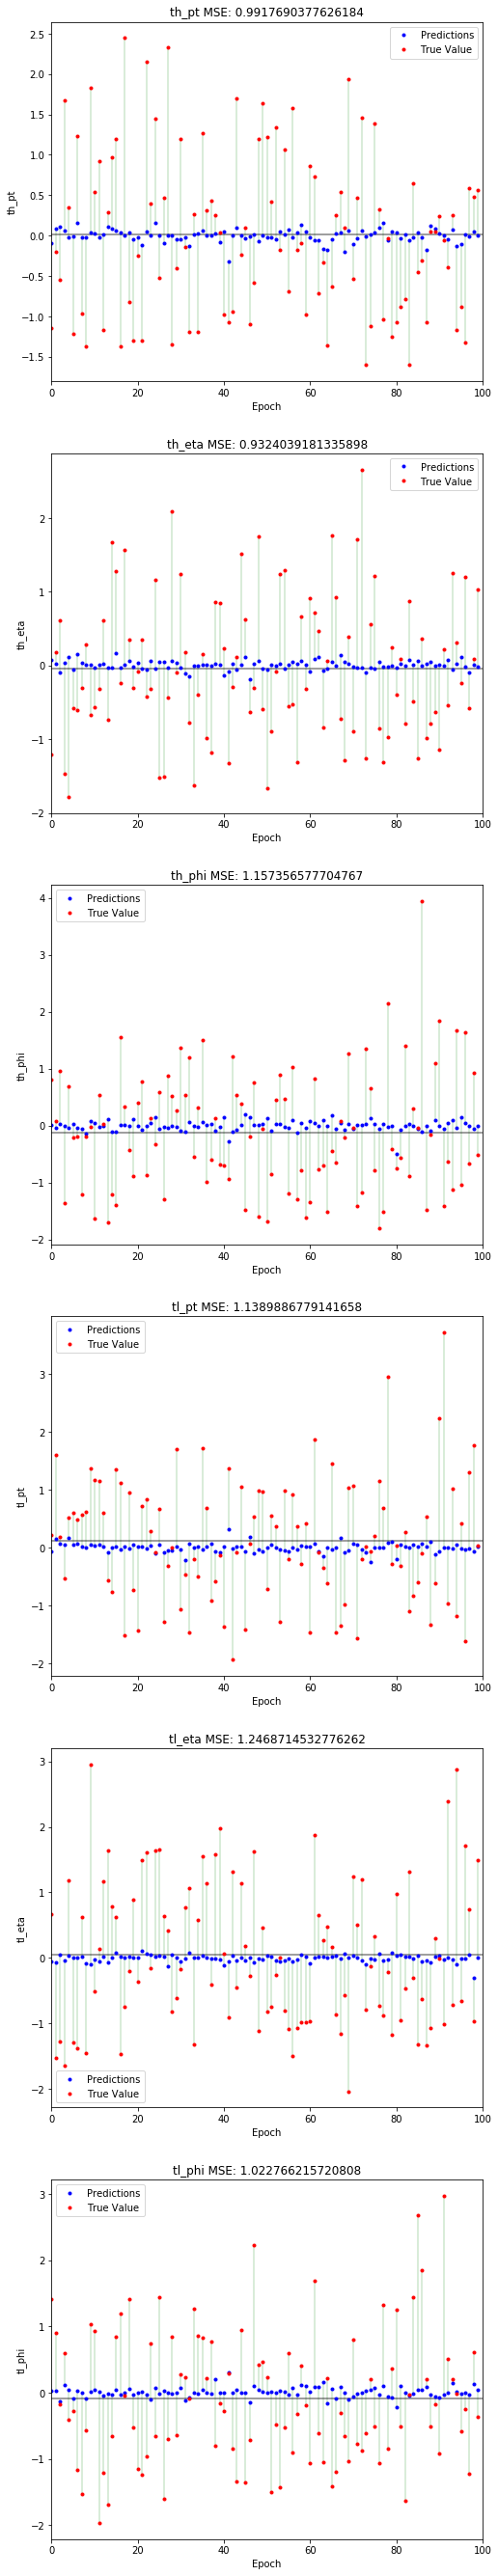

In [17]:
comparison_plot(predictions_small, test_output_small)

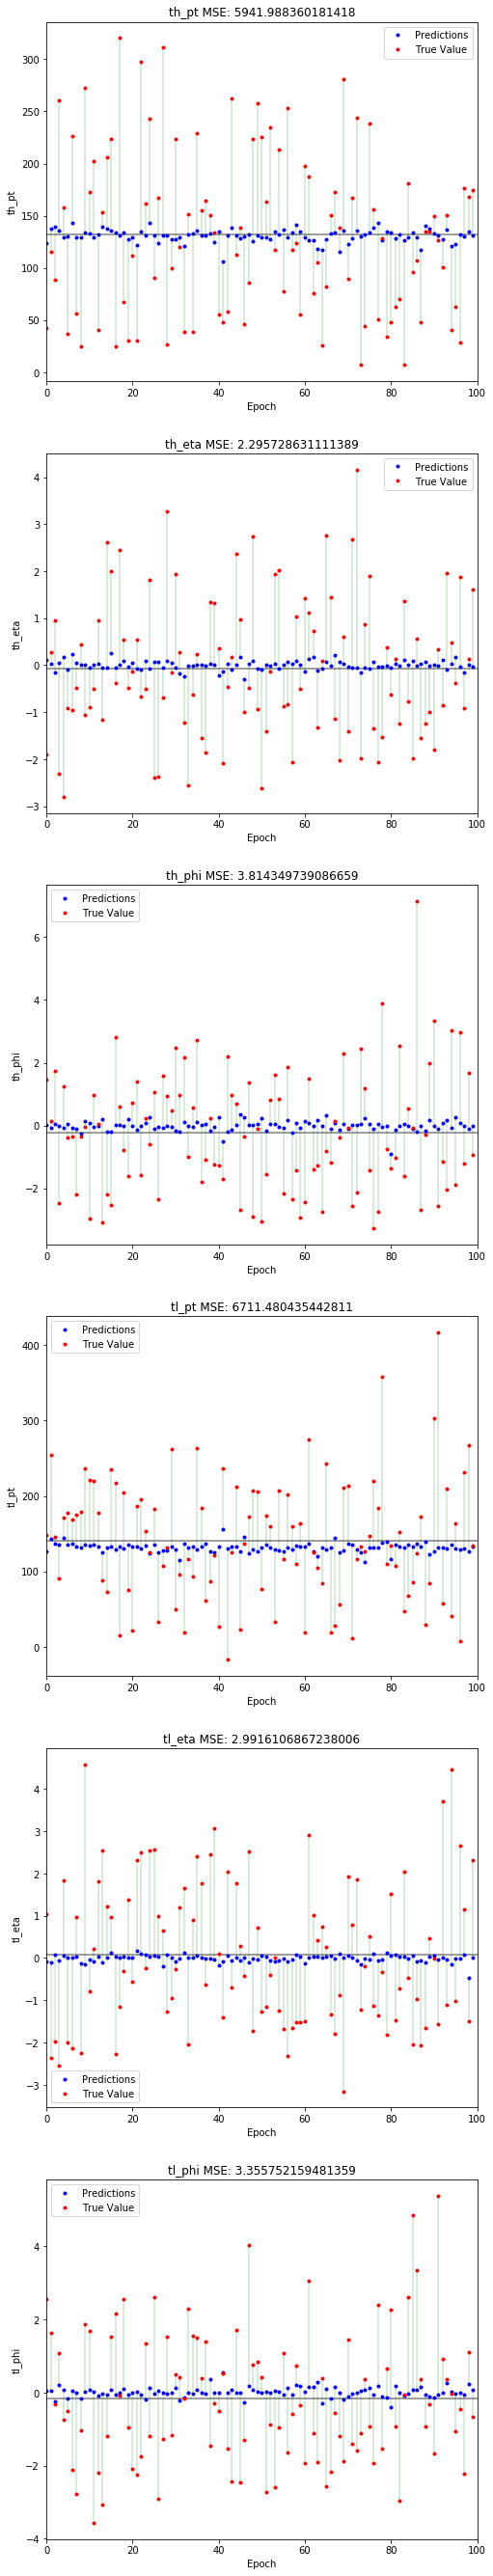

In [18]:
# Back to original units 

scaled_predictions = predictions*out_std + out_mean
scaled_output = test_output*out_std + out_mean

comparison_plot(scaled_predictions[0:crop,:], scaled_output[0:crop,:])


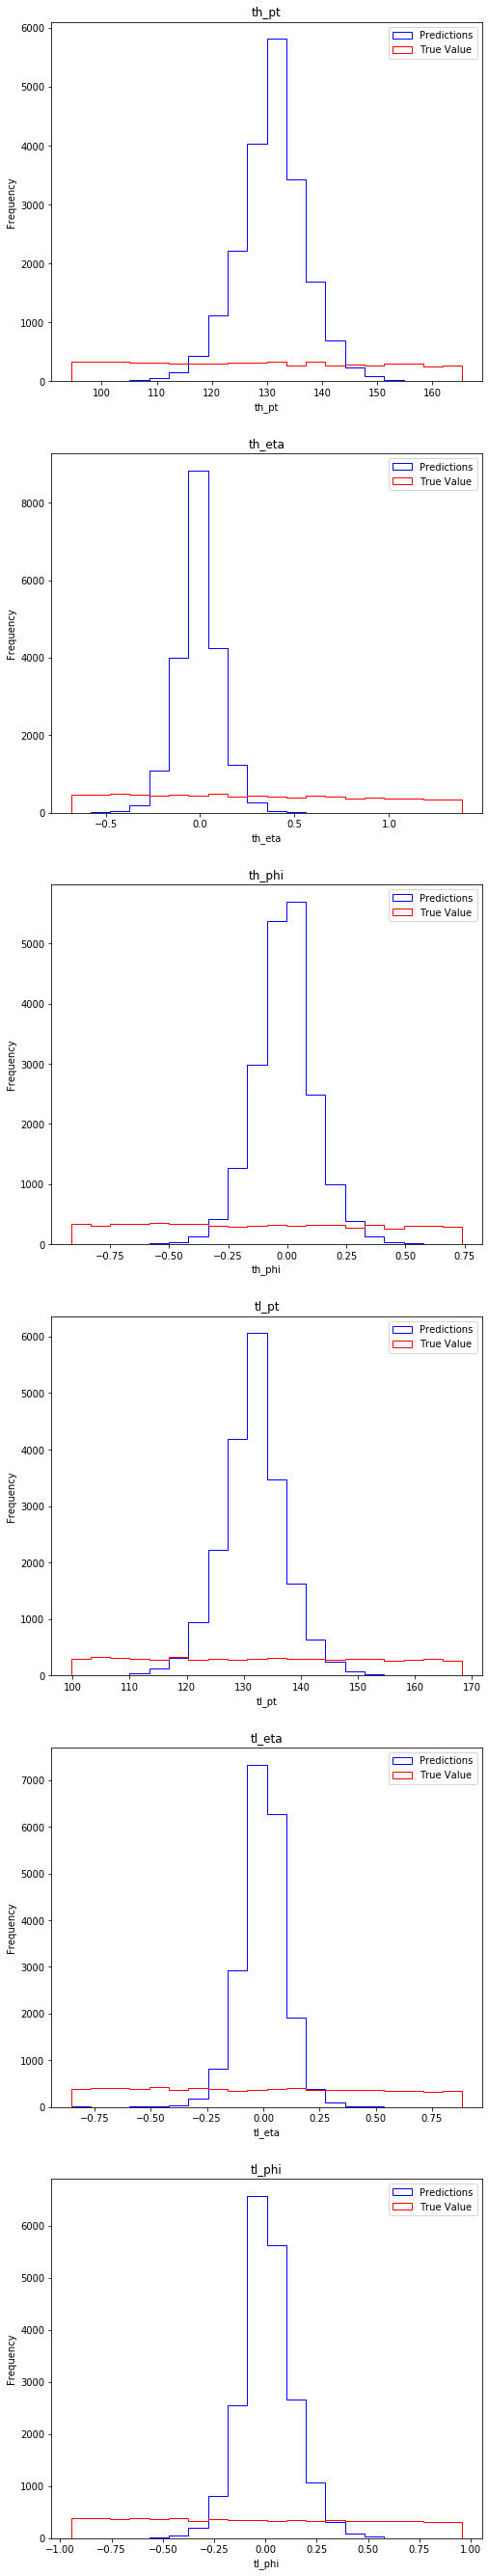

In [19]:
# Histograms 

def histograms(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length,1,i+1)
        histo, bin_edges = np.histogram(compare[:,i],20)
        plt.hist(compare[:,i], bin_edges, histtype = 'step', color='b', label='Predictions')
        plt.hist(true[:,i], bin_edges, histtype = 'step', color='r', label='True Value')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')
        plt.title(output_keys[i])
        plt.legend()

histograms(scaled_predictions, scaled_output)